#  Fashion-MNIST

In [ ]:
import torch
import torch.nn.functional as F
from torch import nn, optim
from torchvision import datasets, transforms

In [ ]:
import numpy as np

In [ ]:
from sklearn import metrics

In [ ]:
%matplotlib inline
from matplotlib import pyplot as plt

### Description

Classification of clothes (FashonMNIST dataset) using a simple multi-layer perceptorn architecture implemented by  subclassing `nn.Module`. The model is tested using a separate test set and the classifier performance is visualised using a confusion matrix.

### Content

1. Loading a training dataset
    1. Apply transformations
    2. Creating a data loader
2. Defining a neural network by subclassing `nn.Module`
3. Training a neural network
4. Evaluation of a multi-class classifier
    1. Test set
    2. Misclassified examples
    3. Confusion matrix

## Data Set

### Fashion MNIST

[Fashion MNIST](https://github.com/zalandoresearch/fashion-mnist) is a drop-in replacement of the original MNIST dataset (same number of examples, same train/test split, same image size, ...) consisting in 10 classes of clothes.

### Loading the Dataset

As usual, we want to load the data into `torch.tensor`s and apply a transformation so that the data is normalised in order to reduce data skewness. Therefore we start by defining a composition of transformations that transforms the data to `torch.tensor`s and apply a normalisation operation:

In [ ]:
transform = transforms.Compose(
    [
        transforms.ToTensor(), # Array to PyTorch tensor
        transforms.Normalize((0.5,), (0.5,)), # Normalisation (mean and std)
    ]
)

Using the transformation we can now download the dataset. We start by downloading the training dataset:

In [ ]:
# Download and load the training dataset
trainset = datasets.FashionMNIST("data", download=True, train=True, transform=transform)

# Create a data loader for the training dataset
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True, drop_last=True)

*Note*: we drop the last batch of images with the option `drop_last=True` so that all the batches contain the same number of images.

The training dataset is used for training and therefore the model's weights will be iteratively changed to minimise the loss on this dataset. However, using this same dataset to evaluate the model performance would not be fair and therefore there is a second dataset for this purpose:

In [ ]:
# Download and load the test dataset
testset = datasets.FashionMNIST("data", download=True, train=False, transform=transform)

# Create a data loader for the test dataset
testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=True, drop_last=True)

*Note*: we drop the last batch of images with the option `drop_last=True` so that all the batches contain the same number of images.

Finally, we can define some commodity iterators to iterate over `tranloader` and `testloader` batches:

In [ ]:
trainiter = iter(trainloader) # Create an iterator from trainloader
testiter = iter(testloader) # Create an iterator from testloader

### Visualizing Images and Labels

Labels are stores as class indices from 0 to 9. However, different classes correspond to different types of clothes and we can therefore create a dictionary that maps a label to the class name:

In [ ]:
label_to_name = { 
    i : name 
    for i, name in enumerate("T-Shirt Trouser Pullover Dress Coat Sandal Shirt Sneaker Bag Boot".split()) 
}

print(label_to_name)

{0: 'T-Shirt', 1: 'Trouser', 2: 'Pullover', 3: 'Dress', 4: 'Coat', 5: 'Sandal', 6: 'Shirt', 7: 'Sneaker', 8: 'Bag', 9: 'Boot'}


We can now visualise a batch of images:

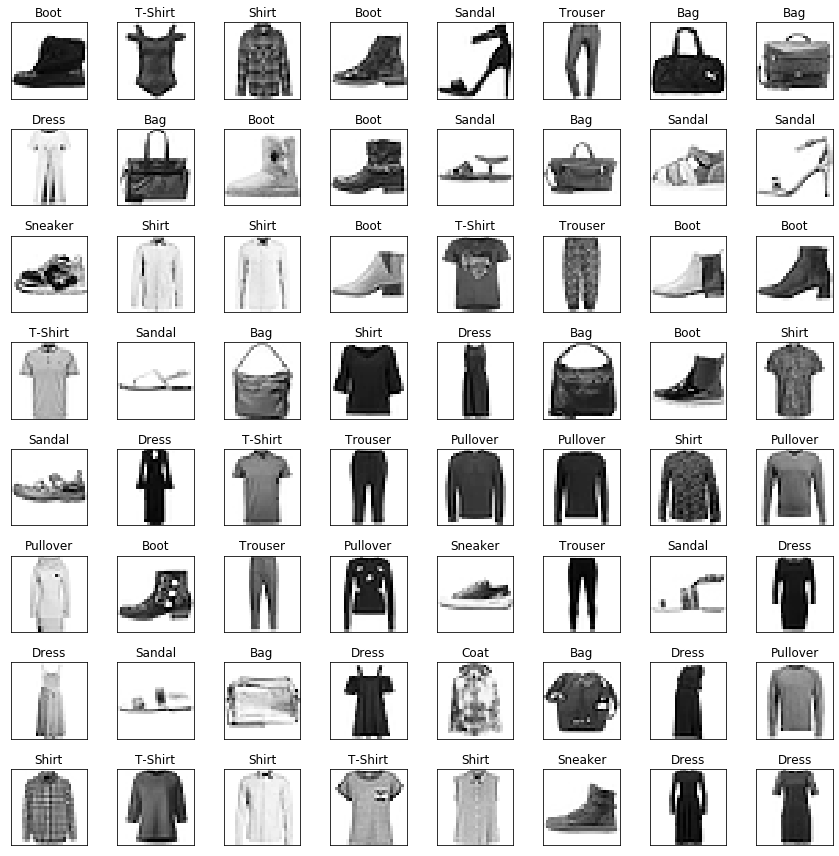

In [ ]:
images, labels = next(trainiter)

fig = plt.figure(figsize=(12,12))
for idx in range(64):
    ax = fig.add_subplot(8, 8, idx + 1, xticks=[], yticks=[])
    
    # Un-normalize image
    img = images[idx].numpy().squeeze() * 0.5 + 0.5
    
    plt.imshow(img, cmap='Greys')
    
    name = label_to_name[labels[idx].item()]
    
    ax.set_title(name, fontdict={"fontsize": 12})

plt.tight_layout()
plt.show()

## Neural Network with PyTorch

Simple neural networks in PyTorch can be easily and quickly defined using the `nn.Sequentual` class that accepts a list of layers (and activation functions) to which the data is passed sequentually. However, for more complex architectures this class is not sufficient. More compelx architectures are usually defined by sub-classing a `nn.Module`. Even if for a multi-layer percepton the `nn.Sequentual` would be enough, let's try to sub-class the `nn.Module`:

In [ ]:
class FashionClassifier(nn.Module):
    
    def __init__(self):
        # Initialise nn.Module superclass
        super().__init__()
        
        # Define fully connected layers
        self.fc1 = nn.Linear(28 * 28, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 64)
        self.fc4 = nn.Linear(64, 10)
        
    def forward(self, x):
        """
        Define forward pass through the network.
        """
        
        # Flatten images (64, 1, 28, 28) to (64, 1 * 28 * 28)
        x = x.view(x.shape[0], -1)
        
        # Input: (64, 784)
        assert x.shape == (64, 784)
        
        x = self.fc1(x) # Fully connected layer
        x = F.relu(x) # Activation
        x = self.fc2(x) # Fully connected layer
        x = F.relu(x) # Activation
        x = self.fc3(x) # Fully connected layer
        x = F.relu(x) # Activation
        x = self.fc4(x) # Fully connected layer
        
        # Output: (64, 10)
        assert x.shape == (64, 10)
        
        # Produce log-probabilities for the 10 classes
        x = F.log_softmax(x, dim=1)
        
        return x

Once the `FashionClassifier` class is defined,  we can instantiate a model:

In [ ]:
# Instanciate the model
model = FashionClassifier()

### Test Forward Pass

In order to check  that our definition works correctly, we can try to propagate one batch of images through the network. We can also plot the class probabilities of this untrained model:

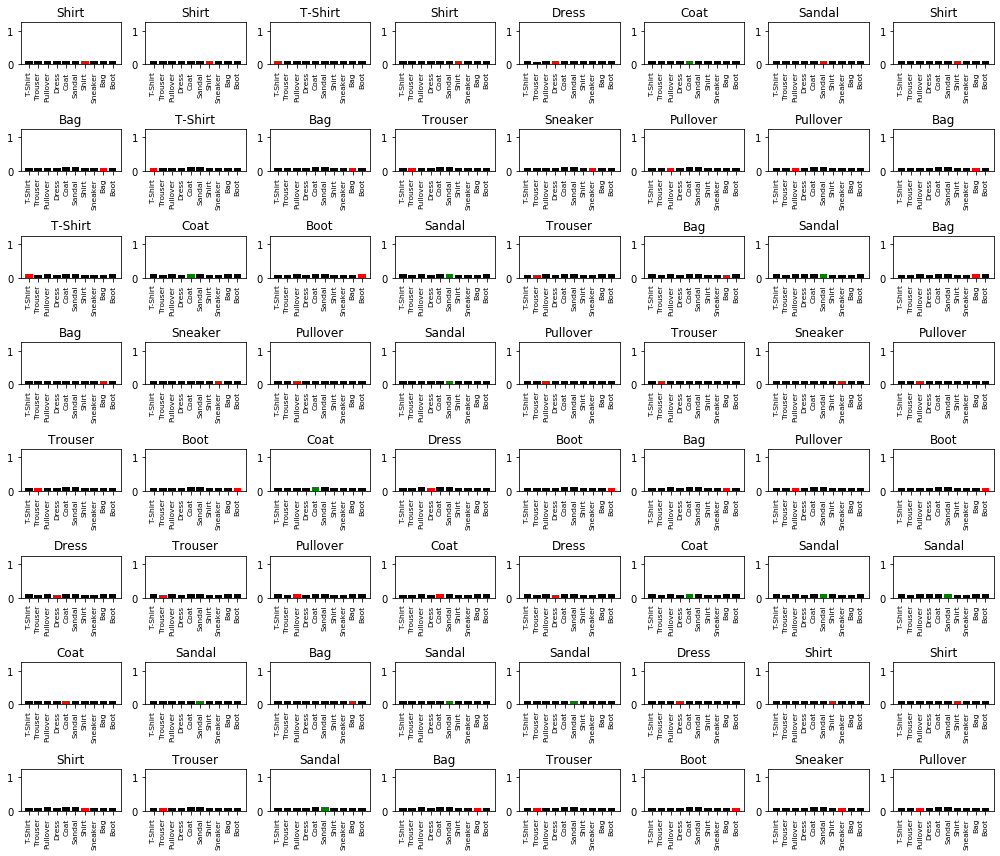

In [ ]:
images, labels = next(trainiter)

def showclassp(images, labels, model, misclassified=False):
    """
    Plot class probabilities for a batch of images and labels.
    """
    
    from collections import namedtuple
    
    # Define named tuple for misclassified images
    # Clearer for printing, reporting batch index and true label
    Misclassified = namedtuple("Misclassified", "index true_label")
    
    # Defint a figure
    fig = plt.figure(figsize=(14,12))
    
    # List of missclassified systems
    failed = []
    
    # Flatten image for forward pass
    images = images.view(images.shape[0], -1)

    # Compute predictions
    with torch.no_grad(): # Do not track gradients
        # Perform forward pass
        out = model(images)
            
        # Compute class probabilities
        # The model returns log-probabilities
        p = torch.exp(out).numpy()

    
    # Loop over images and labels in a batch
    for idx in range(64):
        
        # Create subplot
        ax = fig.add_subplot(8, 8, idx + 1, xticks=range(10), yticks=[0, 1])

        # Plot all class probabilities for given image
        for i in range(10):
            if labels[idx] == i:
                if labels[idx] == np.argmax(p[idx]):
                    plt.bar(i, p[idx,i], color="g")
                else:
                    plt.bar(i, p[idx,i], color="r")
                    
                    # Append misclassified sample
                    failed.append(Misclassified(idx, np.argmax(p[idx])))
            else:
                plt.bar(i, p[idx,i], color="k")
        plt.ylim([0,1.25])
        
        ax.set_xticklabels(label_to_name.values(), rotation=90, fontdict={"fontsize": 7.5})
        
        name = label_to_name[labels[idx].item()]
        ax.set_title(name, fontdict={"fontsize": 12})

    plt.tight_layout()
    plt.show()
    
    return failed if misclassified else  None
    
showclassp(images, labels, model)

As expected, the class probabilities look pretty much the same for each class and are close to $1/10$. We can also compute the accuracy (i.e. the percentage of correctly classified examples):

In [ ]:
# Model prediction probabilities
with torch.no_grad():
    p = torch.exp(model(images))

# Get probability and class of top prediction
top_p, top_c = p.topk(1, dim=1)

# Get truth table for the predicted classes
# Transform torch.ByteTensor type to torch.FloatTensor
equals = (top_c == labels.view(*top_c.shape)).type(torch.FloatTensor)

# Compute accuracy
accuracy = torch.mean(equals)

print(f'Accuracy: {accuracy.item()*100}%')

Accuracy: 20.3125%


Again, this is close to 10%, which is the expected result for a model initialized at random.

### Training

The cross-entropy loss applied to the output of a fully connected layer (*logit*) corresponds to the negative log likelihood loss applied to a log-softmax output. Since our model applies a `F.log_softmax` function at the end of the forward pass, our log function will have to be the `nn.NLLLoss` in order to produce the same output of `nn.CrossEntropyLoss` applied to the logits.

In [ ]:
nnl_loss = nn.NLLLoss()

Finally we can define an optimizer, link it to the model parameters (weights and biases) and set a learning rate.

In [ ]:
optimizer = optim.Adam(model.parameters(), lr=0.003)

With all the ingredients in place we can finally start training. Neural networks are prone to overfitting: they perform well on the training data but fail to generalise to new data. In order to see how our model is performing, we can use the test set in order to validate our model at each epoch.

In [ ]:
# Define the number of training. epochs
epochs = 15

# Variables to keep track of losses during training
train_losses, test_losses = [], []

# Loop over epochs
for epoch in range(epochs):
    
    # Initialize total epoch loss
    epoch_loss = 0
    
    # Training
    for images, labels in trainloader:
    
        # Initialize the gradients to zero
        optimizer.zero_grad()
        
        # Perform forward pass
        output = model(images)
        
        # Compute the loss
        loss = nnl_loss(output, labels)
        
        # Perform backpropagation
        loss.backward()
        
        # Update the weights
        optimizer.step()
        
        # Accumulate total epoch loss
        epoch_loss += loss.item()
    else:
        test_loss = 0
        accuracy = 0
        
        # Validation
        # No need totrack gradients during validation
        with torch.no_grad(): 
            for images, labels in testloader:
                
                # Perform forward pass
                output = model(images)
                
                # Compute class probabilities
                p = torch.exp(output)
                
                # Compute the loss
                test_loss += nnl_loss(output, labels).item()
                
                # Get probability and class of top prediction
                top_p, top_c = p.topk(1, dim=1)

                # Get truth table for the predicted classes
                equals = (top_c == labels.view(*top_c.shape)).type(torch.FloatTensor)

                # Compute accuracy
                accuracy += torch.mean(equals)
                
        # Store losses
        train_losses.append(epoch_loss/len(trainloader))
        test_losses.append(test_loss/len(testloader))
            
        print(f"--- Epoch {epoch+1:2} ---")
        print(f"Train Loss: {train_losses[-1]:.5f}")
        print(f"Test  Loss: {test_losses[-1]:.5f}")
        print(f"Test Accuracy: {accuracy.item()/len(testloader)*100:.2f}%")

--- Epoch  1 ---
Train Loss: 0.51573
Test  Loss: 0.43776
Test Accuracy: 84.22%
--- Epoch  2 ---
Train Loss: 0.39233
Test  Loss: 0.39168
Test Accuracy: 85.87%
--- Epoch  3 ---
Train Loss: 0.35487
Test  Loss: 0.41816
Test Accuracy: 85.40%
--- Epoch  4 ---
Train Loss: 0.33327
Test  Loss: 0.37623
Test Accuracy: 86.45%
--- Epoch  5 ---
Train Loss: 0.31475
Test  Loss: 0.38563
Test Accuracy: 86.33%
--- Epoch  6 ---
Train Loss: 0.30369
Test  Loss: 0.35852
Test Accuracy: 87.56%
--- Epoch  7 ---
Train Loss: 0.28991
Test  Loss: 0.36101
Test Accuracy: 87.12%
--- Epoch  8 ---
Train Loss: 0.28413
Test  Loss: 0.36155
Test Accuracy: 88.07%
--- Epoch  9 ---
Train Loss: 0.27749
Test  Loss: 0.37294
Test Accuracy: 86.74%
--- Epoch 10 ---
Train Loss: 0.26560
Test  Loss: 0.36435
Test Accuracy: 87.69%
--- Epoch 11 ---
Train Loss: 0.25914
Test  Loss: 0.37477
Test Accuracy: 86.87%
--- Epoch 12 ---
Train Loss: 0.25606
Test  Loss: 0.38085
Test Accuracy: 87.53%
--- Epoch 13 ---
Train Loss: 0.24909
Test  Loss: 0.3

Since we kept track of the train loss and the validation loss during training we can plot them easily:

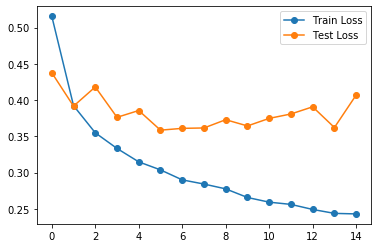

In [ ]:
fig = plt.figure()
plt.plot(train_losses, "o-", label="Train Loss")
plt.plot(test_losses, "o-", label="Test Loss")
plt.legend()
plt.show()

We see that the training loss keeps decreasing while the test loss quickly reaches a plateau.

### Testing

#### Accuracy

We already know that the final accuracy on the test set is

In [ ]:
print(f"Test Accuracy: {accuracy.item()/len(testloader)*100:.2f}%")

Test Accuracy: 86.87%


We can also plot the accuracy for every class:

In [ ]:
def accuracy(model, testloader):
    
    from collections import defaultdict
    
    test_loss = 0.0
    
    class_correct = defaultdict(int)
    class_total = defaultdict(int)
    
    model.eval()
    
    with torch.no_grad(): 
        for images, labels in testloader:
                
            # Perform forward pass
            output = model(images)
                
            # Compute class probabilities
            p = torch.exp(output)
                
            # Compute the loss
            test_loss += nnl_loss(output, labels).item()
                
            # Get class of top prediction
            _, c = torch.max(p, dim=1) 
            
            correct = np.squeeze(c.eq(labels.data.view_as(c)).numpy())
            
            for i in range(64):
                label = labels.data[i].item()
                
                class_correct[label] += correct[i].item()
                class_total[label] += 1
           
    # Average test loss (per example)
    test_loss = test_loss/len(testloader.dataset)
    print(f"Test Loss: {test_loss:.5f}")
    
    total_correct = np.sum([c for _, c in class_correct.items()])
    total = np.sum([c for _, c in class_total.items()])
    
    accuracy = total_correct / total * 100
    print(f"Test Accuracy: {accuracy:.2f} ({total_correct}/{total})\n")
    
    for i in range(10):
        accuracy = class_correct[i] / class_total[i] * 100
        print(f"{label_to_name[i]:10}: {accuracy:.2f} ({class_correct[i]:3}/{class_total[i]:4})")
    
accuracy(model, testloader)

Test Loss: 0.00635
Test Accuracy: 86.89 (8675/9984)

T-Shirt   : 74.55 (744/ 998)
Trouser   : 96.19 (959/ 997)
Pullover  : 72.12 (719/ 997)
Dress     : 91.28 (911/ 998)
Coat      : 83.30 (833/1000)
Sandal    : 88.38 (882/ 998)
Shirt     : 74.80 (748/1000)
Sneaker   : 97.30 (973/1000)
Bag       : 95.79 (956/ 998)
Boot      : 95.19 (950/ 998)


#### Misclassified Examples

We can look at one test batch to spot the misclassified examples:

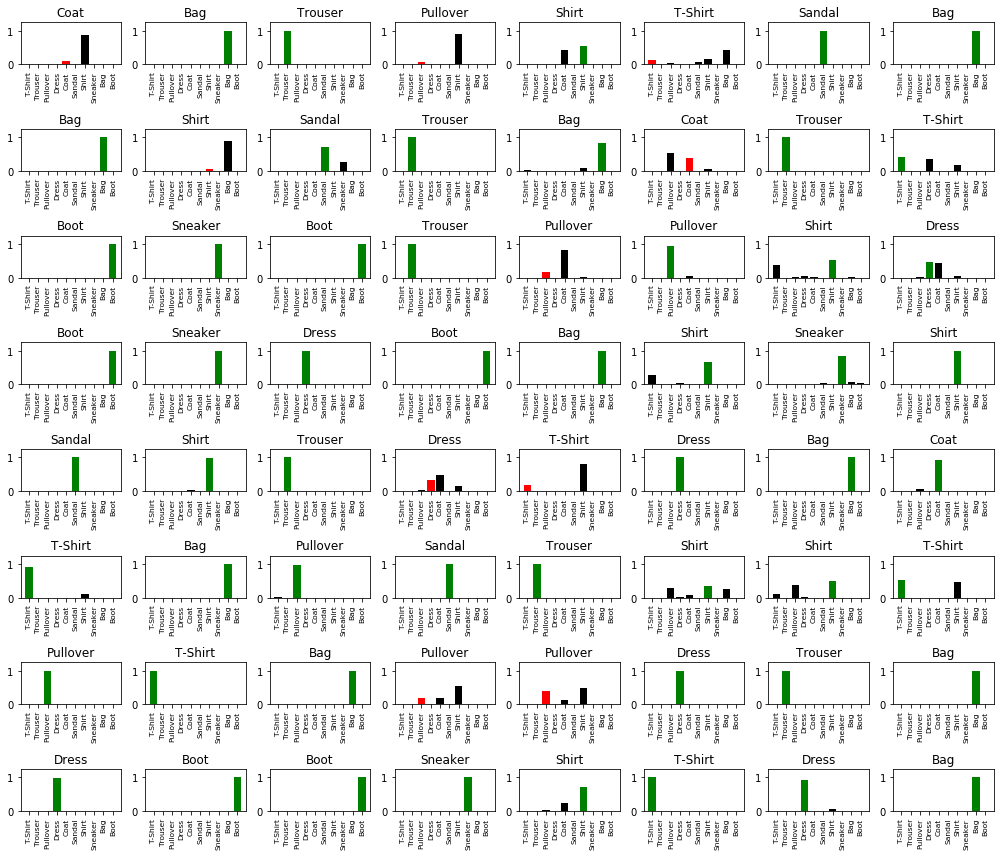

In [ ]:
images, labels = next(testiter)

misclassified = showclassp(images, labels, model, misclassified=True)

The misclassified images for this particular batch are the following:

In [ ]:
print(misclassified)

[Misclassified(index=0, true_label=6), Misclassified(index=3, true_label=6), Misclassified(index=5, true_label=8), Misclassified(index=9, true_label=8), Misclassified(index=13, true_label=2), Misclassified(index=20, true_label=4), Misclassified(index=35, true_label=4), Misclassified(index=36, true_label=6), Misclassified(index=51, true_label=6), Misclassified(index=52, true_label=6)]


We can also plot all the misclassified examples:

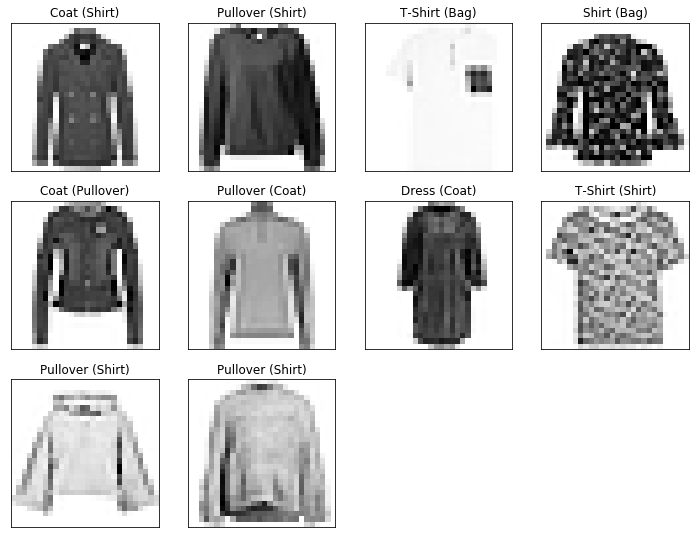

In [ ]:
# Define grid size for the subplot
n = int(np.sqrt(len(misclassified)) + 1)

fig = plt.figure(figsize=(10,10))
for i, (idx, true_label) in enumerate(misclassified):
    ax = fig.add_subplot(n, n, i + 1, xticks=[], yticks=[])
    
    # Un-normalize image
    img = images[idx].numpy().squeeze() * 0.5 + 0.5
    plt.imshow(img, cmap='Greys')
    
    name = label_to_name[labels[idx].item()]
    true_name = label_to_name[true_label]
    
    ax.set_title(f"{name} ({true_name})", fontdict={"fontsize": 12})

plt.tight_layout()
plt.show()

We see that the misclassified examples are sometimes difficult for humans too!

#### Confusion Matrix

The confusion matrix is a great tool to assess the quality of a multi-class classifier and spot patterns in misclassified examples. To compute the confusion matrix we can predicted the classes of our test dataset with our model and use `sklearn.metrics.confusion_matrix` to get the confusion matrix:

In [ ]:
def confusion(model, testloader):
    n = len(testloader) * 64
    
    y_pred = np.zeros(n)
    y_true =np.zeros(n)
    
    i = 0
    
    model.eval()
    
    with torch.no_grad(): 
        for images, labels in testloader:
                
            # Perform forward pass
            output = model(images)
                
            # Compute class probabilities
            p = torch.exp(output)
                
            # Get class of top prediction
            p, c = torch.max(p, dim=1) 
            
            y_pred[i*64:i*64+64] = c.numpy()
            y_true[i*64:i*64+64] = labels.numpy()
            
            i += 1
            
    assert i == len(testloader)
    
    C = metrics.confusion_matrix(y_true, y_pred)
    
    for idx in range(10):
        C[idx,:] = C[idx,:] / np.sum(C[idx, :]) * 100
    
    return C
    
C = confusion(model, testloader)

The confusion matrix was (manually) normalised and therefore we can check that on the diagonal we get the previously computed accuracy:

In [ ]:
print(C.diagonal())

[74 96 71 91 83 88 74 97 95 95]


Finally we can visualise the confusion matrix:

Text(0, 0.5, 'True Label')

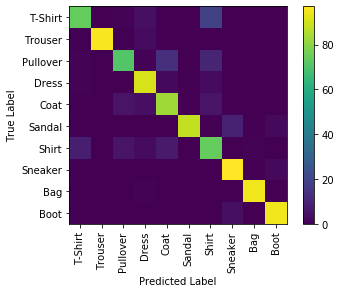

In [ ]:
plt.imshow(C)
plt.xticks(range(10), label_to_name.values(), rotation=90)
plt.yticks(range(10), label_to_name.values())
plt.colorbar()
plt.xlabel("Predicted Label")
plt.ylabel("True Label")

We see that our model sometimes mistakes a pullover and a t-shirt with a shirt and a coat with a pullover. Sneakers and sandals or boots are sometimes swapped as well.